In [1]:
from IPython.display import display
import IPython
import pandas as pd
from pandas import Series
import numpy as np
from random import randrange

from matplotlib import pyplot
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# np.float_ = np.float64
# from prophet import Prophet

import math
from typing import Any, List, Dict, AnyStr, Optional
from pathlib import Path
from glob import glob

from utils.dataset import MarketData
from utils.windowgenerator import WindowGenerator, compile_and_fit
import tensorflow as tf
import talib as ta

%load_ext autoreload
%autoreload 2

In [2]:
def calculate_rolling_mean(df, column_name, window):
    """
    Calculate the rolling mean (SMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the rolling mean.
    window (int): The window size for calculating the rolling mean.
    
    Returns:
    pd.Series: A Pandas Series containing the rolling mean values.
    """
    return df[column_name].rolling(window=window).mean()

def calculate_ema(df, column_name, window):
    """
    Calculate the Exponential Moving Average (EMA) for a specific column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the time series data.
    column_name (str): The column name on which to calculate the EMA.
    window (int): The window size for calculating the EMA.
    
    Returns:
    pd.Series: A Pandas Series containing the EMA values.
    """
    return ta.EMA(df[column_name], timeperiod=window)

def merge_auc_cot(auction_df, cot_df):
    # Merge DataFrames
    merged_df = pd.merge_asof(auction_df, cot_df, on='Date', direction='backward')
    merged_df.ffill(inplace=True)
    merged_df.bfill(inplace=True)
    
    # Drop unnecessary columns
    merged_df.drop(["Spot Value", "Median Price"], axis=1, inplace=True)
    
    # Calculate percentage change in Auc Price
    merged_df.loc[:, 'Pct_Change_Auc_Price'] = merged_df['Auc Price'].pct_change() * 100
    merged_df = merged_df.dropna(subset=['Pct_Change_Auc_Price'])

    merged_df.dropna(inplace=True)

    return merged_df

def MA_features(merged_df):
    ### Rolling Means and Exponential Moving Averages
    merged_df['7 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 MA Premium/discount-settle'] = ta.SMA(merged_df['Premium/discount-settle'], timeperiod=20)
    merged_df['7 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=7)
    merged_df['20 EMA Premium/discount-settle'] = ta.EMA(merged_df['Premium/discount-settle'], timeperiod=20)
    
    merged_df['7 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 MA net_speculators'] = ta.SMA(merged_df['net_speculators'], timeperiod=20)
    merged_df['7 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=7)
    merged_df['20 EMA net_speculators'] = ta.EMA(merged_df['net_speculators'], timeperiod=20)
    
    merged_df['7 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 MA spec_long_%'] = ta.SMA(merged_df['spec_long_%'], timeperiod=20)
    
    merged_df['7 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=7)
    merged_df['20 EMA spec_long_%'] = ta.EMA(merged_df['spec_long_%'], timeperiod=20)

    return merged_df

def LAG_features(merged_df):
    ### Lagged Features
    merged_df['delta_auc'] = merged_df['Auc Price'].diff(2)
    merged_df['delta_auc_4'] = merged_df['Auc Price'].diff(4)
    merged_df['auc_T-2'] = merged_df['Auc Price'].shift(2)
    merged_df['auc_T-4'] = merged_df['Auc Price'].shift(4)

    merged_df['delta_ls'] = merged_df['Long/Short'].diff(2)
    merged_df['delta_ls_4'] = merged_df['Long/Short'].diff(4)
    merged_df['ls_T-2'] = merged_df['Long/Short'].shift(2)
    merged_df['ls_T-4'] = merged_df['Long/Short'].shift(4)
    
    merged_df['delta_net_spec_2'] = merged_df['net_speculators'].diff(2)
    merged_df['delta_net_spec_4'] = merged_df['net_speculators'].diff(4)
    merged_df['net_spec_T-2'] = merged_df['net_speculators'].shift(2)
    merged_df['net_spec_T-4'] = merged_df['net_speculators'].shift(4)

    merged_df['delta_spec_long_2'] = merged_df['spec_long_%'].diff(2)
    merged_df['delta_spec_long_4'] = merged_df['spec_long_%'].diff(4)
    merged_df['spec_long_T-2'] = merged_df['spec_long_%'].shift(2)
    merged_df['spec_long_T-4'] = merged_df['spec_long_%'].shift(4)

    merged_df['delta_spec_short_2'] = merged_df['spec_short_%'].diff(2)
    merged_df['delta_spec_short_4'] = merged_df['spec_short_%'].diff(4)
    merged_df['spec_short_T-2'] = merged_df['spec_short_%'].shift(2)
    merged_df['spec_short_T-4'] = merged_df['spec_short_%'].shift(4)

    return merged_df

def momentum_and_volatility_features(merged_df):
    ### Momentum and Volatility Features
    merged_df['RSI_Auc_Price'] = ta.RSI(merged_df['Auc Price'], timeperiod=14)
    merged_df['Momentum_Auc_Price'] = ta.MOM(merged_df['Auc Price'], timeperiod=10)
    merged_df['Volatility_Auc_Price'] = ta.STDDEV(merged_df['Auc Price'], timeperiod=5, nbdev=1)
    
    ### Additional Indicators
    # merged_df['Upper_Band'], merged_df['Middle_Band'], merged_df['Lower_Band'] = ta.BBANDS(merged_df['Auc Price'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    # merged_df['MACD_Auc_Price'], _, _ = ta.MACD(merged_df['Auc Price'], fastperiod=12, slowperiod=26, signalperiod=9)
    # merged_df['ATR'] = ta.ATR(merged_df['Auc Price'], merged_df['Auc Price'], merged_df['Auc Price'], timeperiod=14)

    return merged_df




## LOADING DATASET

In [10]:
cot_df, auction_df, eua_df, ta_df, fundamentals_df = MarketData.latest(Path('data'))
cot_df = cot_df.set_index('Date').resample('W', origin='end').mean().reset_index()
auction_df = auction_df.set_index('Date').resample('D').mean().reset_index()

print(f"COT Cols: {list(cot_df.columns)}")
print(f"AUC Cols: {list(auction_df.columns)}")

merged_df = merge_auc_cot(auction_df, cot_df)
# merged_df = MA_features(merged_df)
# merged_df = LAG_features(merged_df)
# merged_df = momentum_and_volatility_features(merged_df)
merged_df = merged_df.dropna()

COT Cols: ['Date', 'net_speculators', 'spec_long_%', 'spec_short_%', 'Long/Short']
AUC Cols: ['Date', 'Auc Price', 'Median Price', 'Cover Ratio', 'Spot Value', 'Auction Spot Diff', 'Median Spot Diff', 'Premium/discount-settle']


In [118]:
merged_df.set_index("Date").to_excel('data/feature-engineering.xlsx')

In [21]:
def train_test_data(merged_df, features = []):
    print(features)
    if len(features) == 0:
        print('here')
        FEATURES = ['Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       'delta_auc', 'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls',
       'delta_ls_4', 'ls_T-2', 'ls_T-4']
        
    else: 
        FEATURES = [feature for feature in features if feature != 'Date']
    train_df = merged_df[merged_df['Date'] <
                        "2024-02-01"].copy().set_index('Date')[FEATURES].copy()
    
    val_df = merged_df[(merged_df['Date'] >= "2024-02-01") & (merged_df['Date'] < "2024-07-01")].copy().set_index('Date')[FEATURES].copy()
    
    test_df = merged_df[merged_df['Date'] >= "2024-07-01"].copy().set_index('Date')[FEATURES].copy()

    return train_df, test_df, val_df

def normalize(train_df, test_df, val_df):
    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    return train_df, test_df, val_df

def compile_and_fit(model, window, patience=2, MAX_EPOCHS = 20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

#   history = model.fit(window.train, epochs=MAX_EPOCHS,
#                       validation_data=window.val,
#                       callbacks=[early_stopping])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


FEATURES = merged_df.columns
train_df, test_df, val_df = train_test_data(merged_df, features=FEATURES)
train_df, test_df, val_df = normalize(train_df, test_df, val_df)

print(f"Train Data Shape: {train_df.shape}")
print(f"Val Data Shape: {val_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Index(['Date', 'Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price'],
      dtype='object')
Train Data Shape: (2067, 10)
Val Data Shape: (151, 10)
Test Data Shape: (25, 10)


In [12]:
NUM_OF_FEATURES = train_df.shape[1]
column_indices = {name: i for i, name in enumerate(merged_df.columns)}
# LABEL_COLS = ['Premium/discount-settle']
# LABEL_COL = 'Premium/discount-settle'
LABEL_COLS = ['Auc Price']
LABEL_COL = 'Auc Price'


In [13]:
train_df

,Auc Price,Cover Ratio,Auction Spot Diff,Median Spot Diff,Premium/discount-settle,net_speculators,spec_long_%,spec_short_%,Long/Short,Pct_Change_Auc_Price
Date,,,,,,,,,,
2018-06-05,-1.230799,0.469869,0.013506,-0.104282,0.428820,0.601915,-0.575937,-1.380205,5.071801,2.903419
2018-06-06,-1.254701,0.521019,-0.127861,-0.109175,0.428820,0.601915,-0.575937,-1.380205,5.071801,-1.711958
2018-06-07,-1.238521,0.538069,0.614314,-0.099389,0.428820,0.601915,-0.575937,-1.380205,5.071801,1.137648
2018-06-08,-1.251759,-0.399681,-0.057178,-0.101836,0.428820,0.601915,-0.575937,-1.380205,5.071801,-0.978312
2018-06-09,-1.251759,-0.399681,-0.057178,-0.101836,0.428820,0.601915,-0.575937,-1.380205,5.071801,-0.040585
...,...,...,...,...,...,...,...,...,...,...
2024-01-27,0.446028,0.111819,3.335623,-0.137310,3.163772,-2.119335,-0.536046,3.711778,-1.132019,-0.040585
2024-01-28,0.446028,0.111819,3.335623,-0.137310,3.163772,-2.082004,-0.476209,3.643091,-1.122964,-0.040585
2024-01-29,0.404108,-1.013481,-1.011403,-0.134864,-0.882264,-2.082004,-0.476209,3.643091,-1.122964,-0.814229


### BASE LINE & REPEAT BASELINE

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.7304 - mean_absolute_error: 0.4057
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.7369 - mean_absolute_error: 0.4282


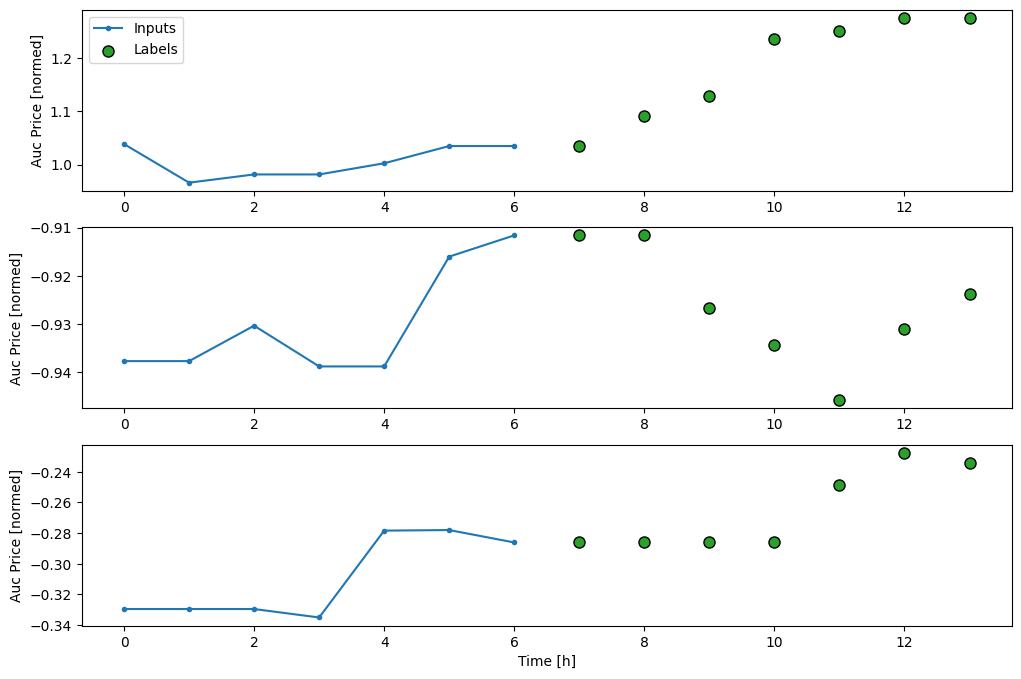

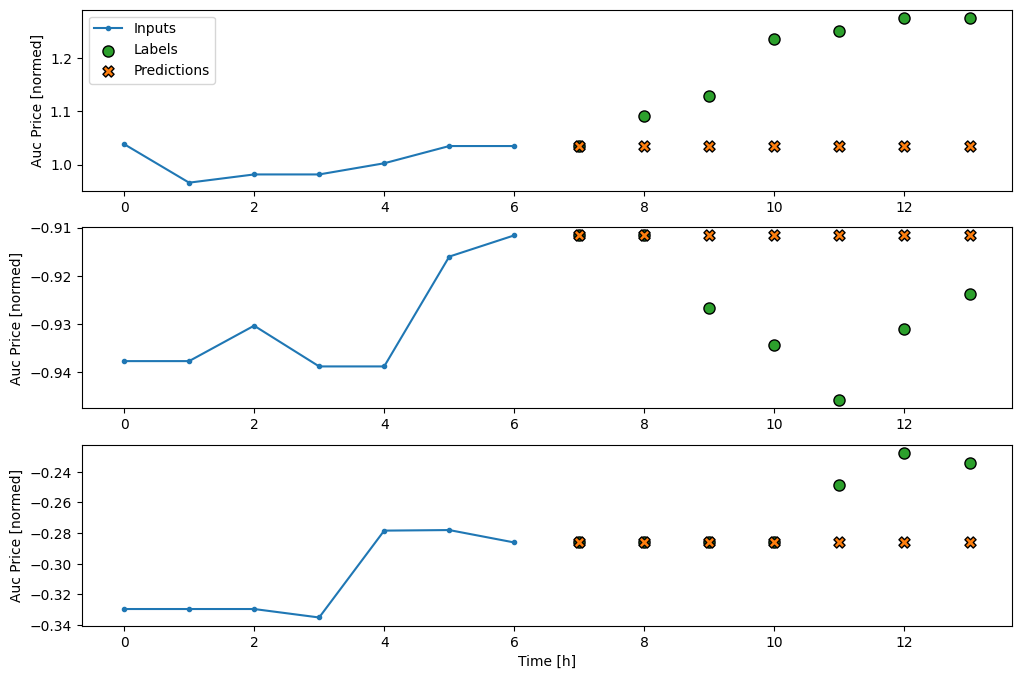

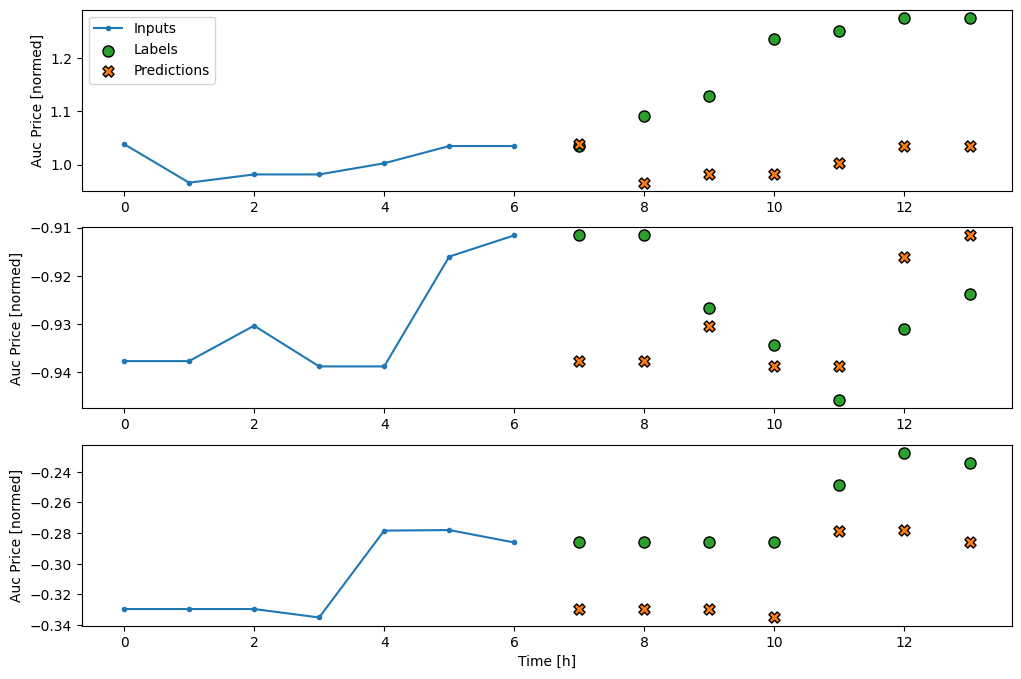

In [14]:
OUT_STEPS = 7
INPUT_STEPS = 7
multi_window = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               test_df=test_df,
                               val_df=val_df)

multi_window.plot()
multi_window

class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(repeat_baseline)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 1.8309 - mean_absolute_error: 0.9462


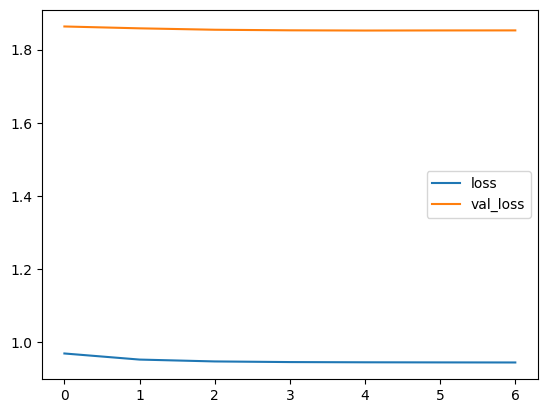

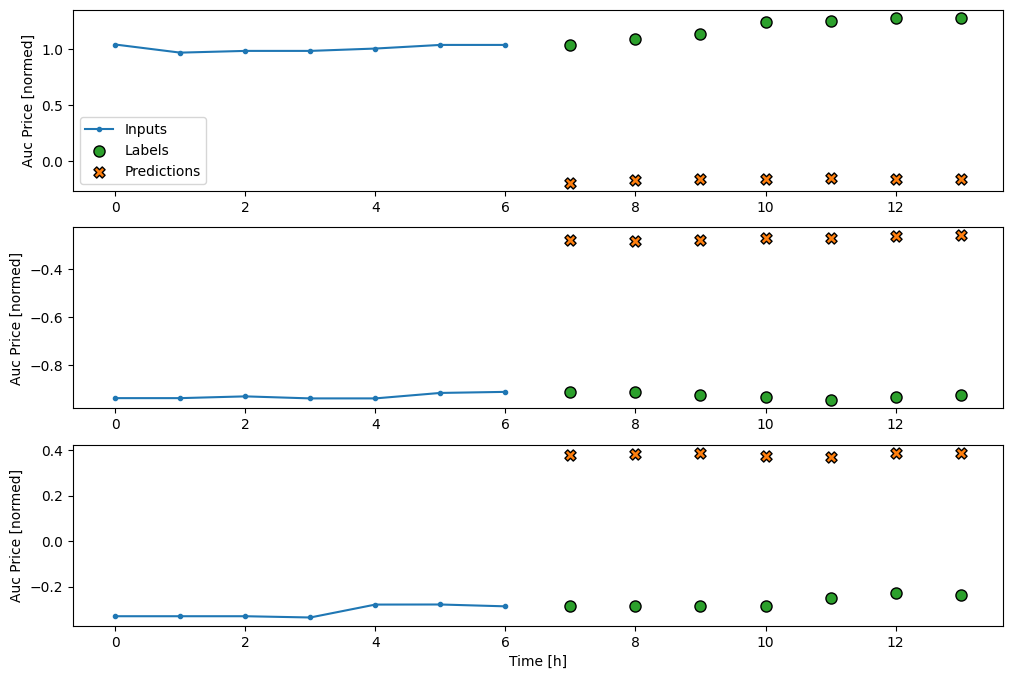

In [22]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_linear_model, multi_window, MAX_EPOCHS=100)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_linear_model)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 1.8406 - mean_absolute_error: 0.9355


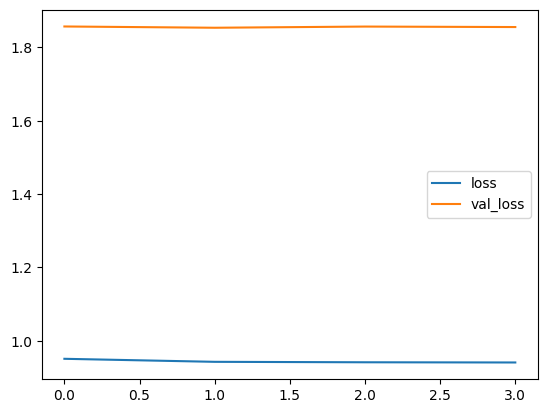

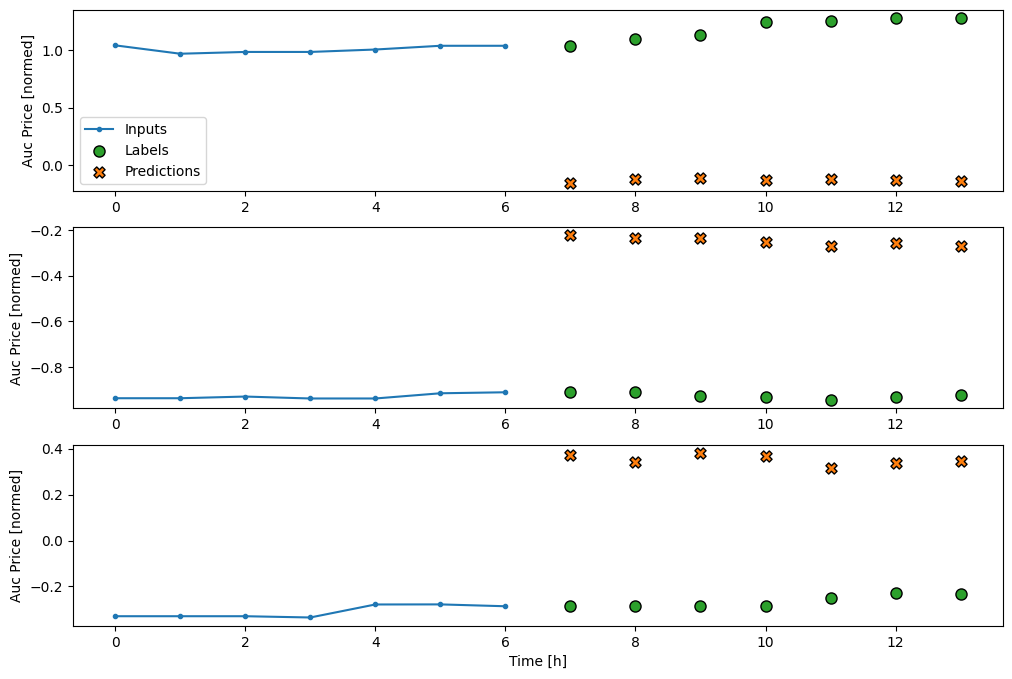

In [23]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_dense_model, multi_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 1.8734 - mean_absolute_error: 0.9336


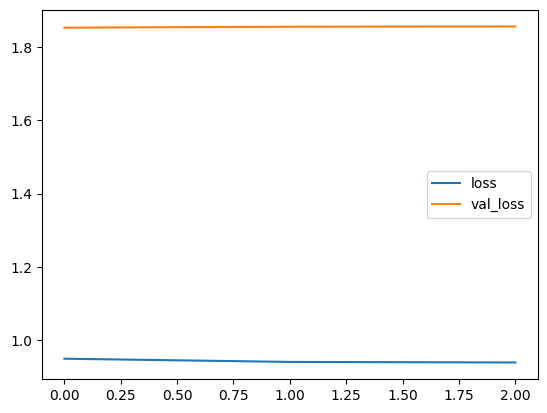

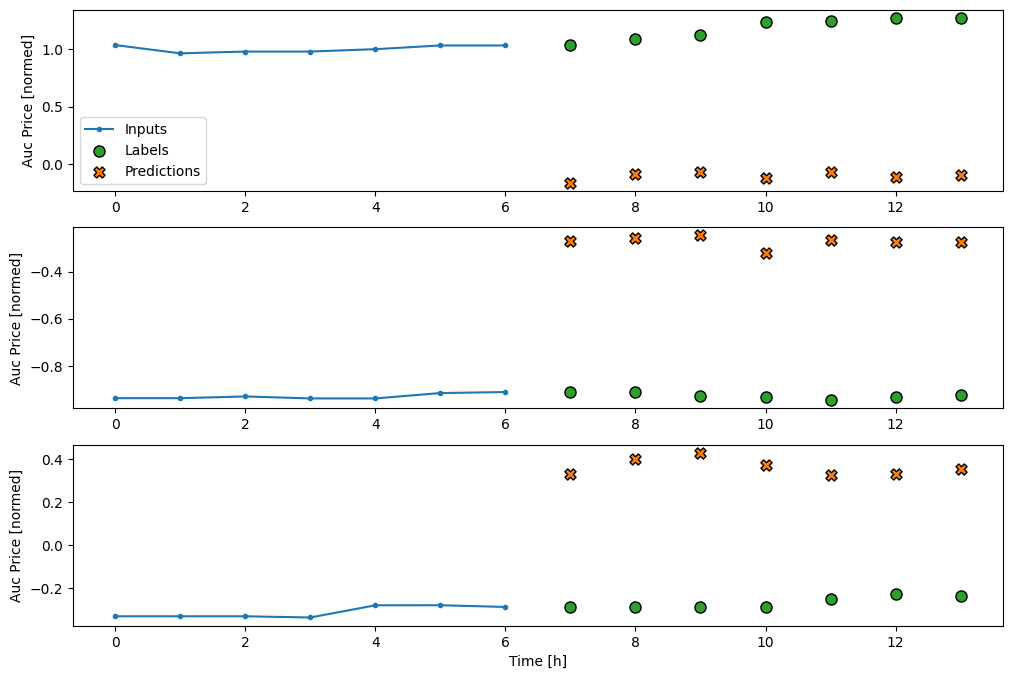

In [24]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.4382 - mean_absolute_error: 0.3941


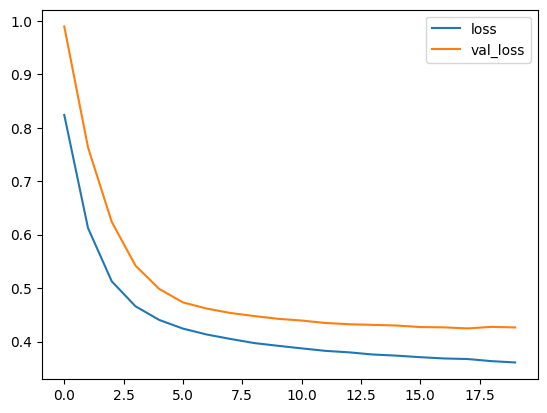

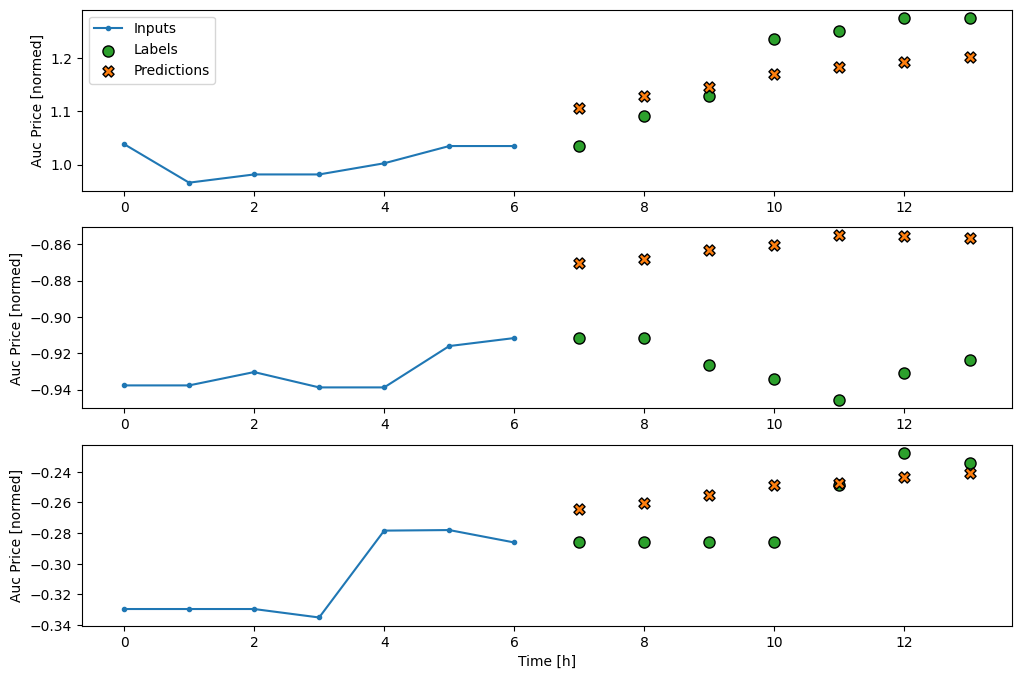

In [25]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*NUM_OF_FEATURES,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, NUM_OF_FEATURES])
])

history = compile_and_fit(multi_lstm_model, multi_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [29]:
check = multi_window.test

In [36]:
check = check.take(1)

In [40]:
for i in check.as_numpy_iterator():
    print(i)

(array([[[ 0.626949  , -1.3374317 , -1.4708444 , -0.10672857,
         -1.1614845 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -1.9204385 ],
        [ 0.64239347,  0.43576917, -0.5166193 , -0.13608684,
         -0.35306874, -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 ,  0.22347133],
        [ 0.61849135, -0.9623315 , -0.12786093, -0.11651465,
         -0.03014213, -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -0.4466917 ],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 ,  0.19283897],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -0.04058452],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6675627 , -0.7355029 ,  1.866392  ,
         -1.043566  , -0.04058452],
        [ 0.61076915, -0.70658135,  0.6849975 , -0.

2024-09-02 17:32:55.888413: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [43]:
i[1]

array([[[ 0.626949  , -1.3374317 , -1.4708444 , -0.10672857,
         -1.1614845 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -1.9204385 ],
        [ 0.64239347,  0.43576917, -0.5166193 , -0.13608684,
         -0.35306874, -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 ,  0.22347133],
        [ 0.61849135, -0.9623315 , -0.12786093, -0.11651465,
         -0.03014213, -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -0.4466917 ],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 ,  0.19283897],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6468762 , -0.6477419 ,  1.9533954 ,
         -1.0379394 , -0.04058452],
        [ 0.6320972 , -0.46788123, -0.33991095, -0.12018444,
         -0.2075639 , -1.6675627 , -0.7355029 ,  1.866392  ,
         -1.043566  , -0.04058452],
        [ 0.61076915, -0.70658135,  0.6849975 , -0.1

In [109]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(NUM_OF_FEATURES)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                    training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


feedback_model = FeedBack(units=7, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 7, 45)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.6383 - mean_absolute_error: 0.5068


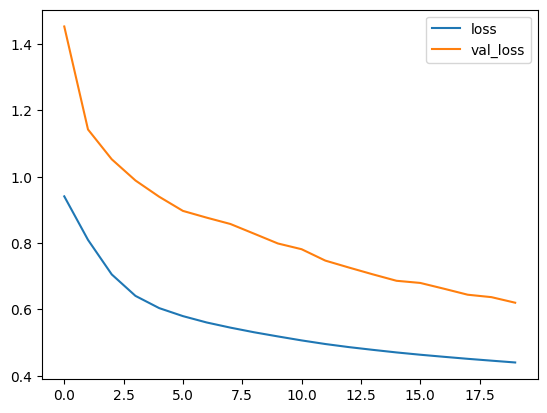

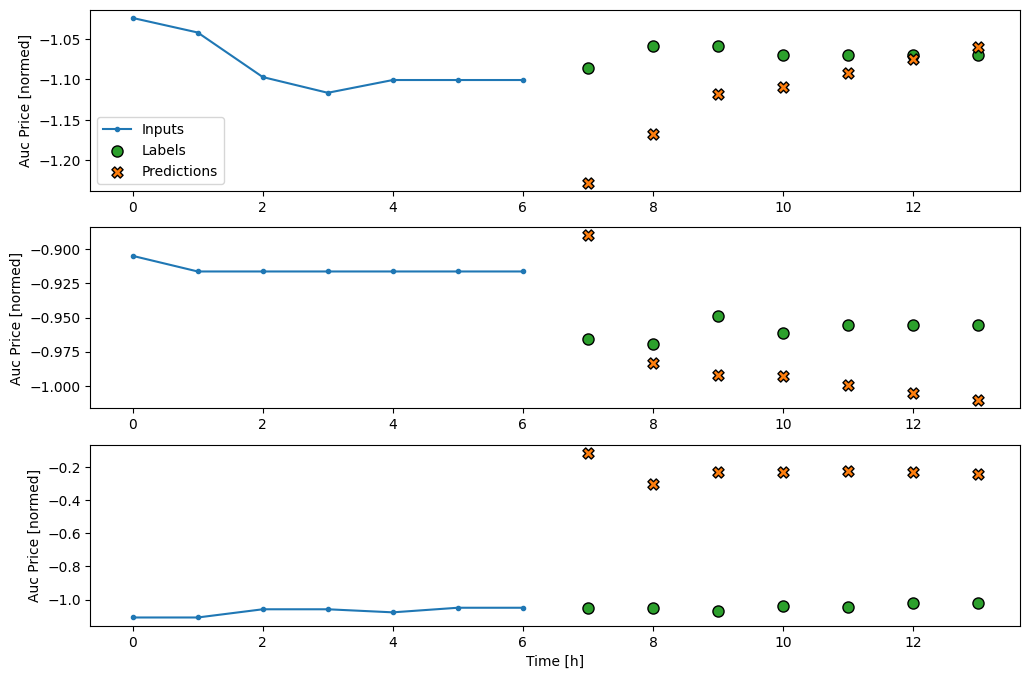

In [110]:
history = compile_and_fit(feedback_model, multi_window)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, return_dict=True)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(feedback_model)

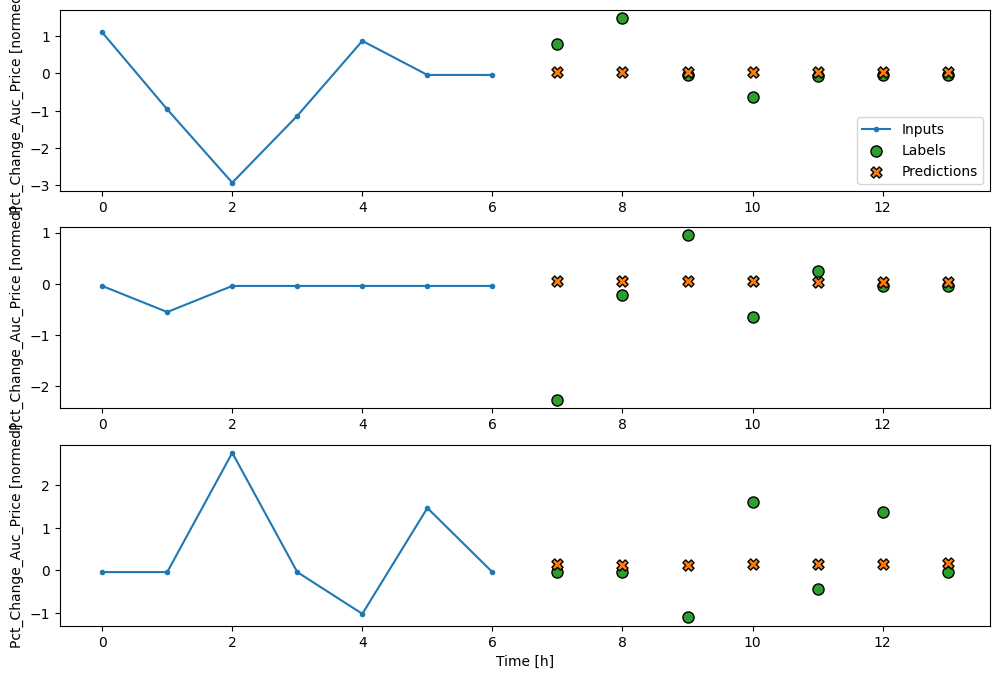

In [111]:
multi_window.plot(feedback_model, 'Pct_Change_Auc_Price')

In [112]:
merged_df.columns

Index(['Date', 'Auc Price', 'Cover Ratio', 'Auction Spot Diff',
       'Median Spot Diff', 'Premium/discount-settle', 'net_speculators',
       'spec_long_%', 'spec_short_%', 'Long/Short', 'Pct_Change_Auc_Price',
       '7 MA Premium/discount-settle', '20 MA Premium/discount-settle',
       '7 EMA Premium/discount-settle', '20 EMA Premium/discount-settle',
       '7 MA net_speculators', '20 MA net_speculators',
       '7 EMA net_speculators', '20 EMA net_speculators', '7 MA spec_long_%',
       '20 MA spec_long_%', '7 EMA spec_long_%', '20 EMA spec_long_%',
       'delta_auc', 'delta_auc_4', 'auc_T-2', 'auc_T-4', 'delta_ls',
       'delta_ls_4', 'ls_T-2', 'ls_T-4', 'delta_net_spec_2',
       'delta_net_spec_4', 'net_spec_T-2', 'net_spec_T-4', 'delta_spec_long_2',
       'delta_spec_long_4', 'spec_long_T-2', 'spec_long_T-4',
       'delta_spec_short_2', 'delta_spec_short_4', 'spec_short_T-2',
       'spec_short_T-4', 'RSI_Auc_Price', 'Momentum_Auc_Price',
       'Volatility_Auc_Price'],

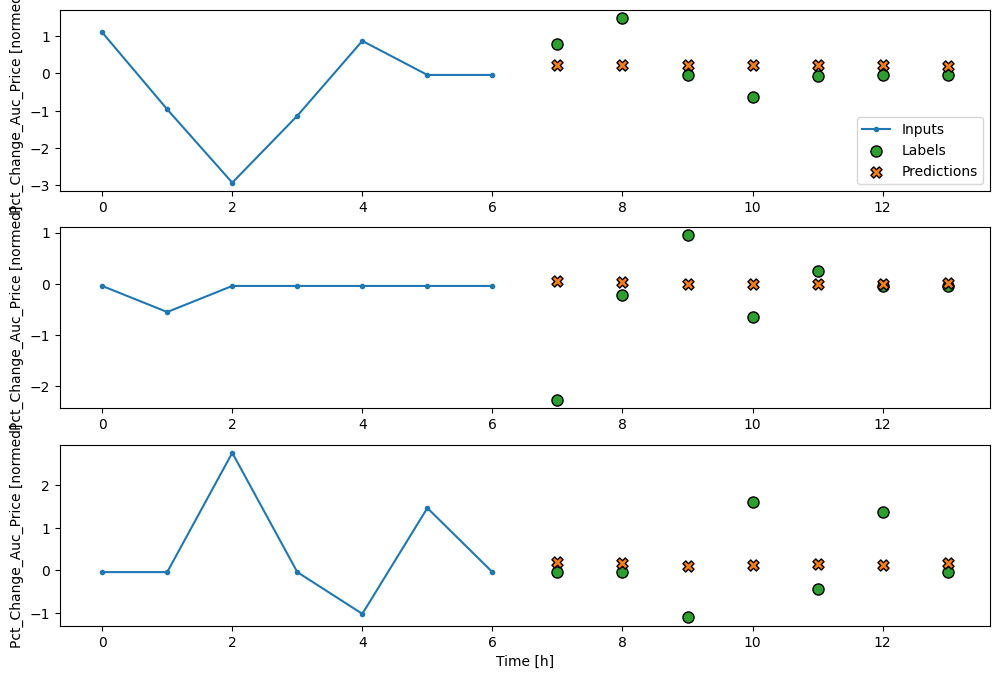

In [113]:
multi_window.plot(multi_lstm_model, 'Pct_Change_Auc_Price')

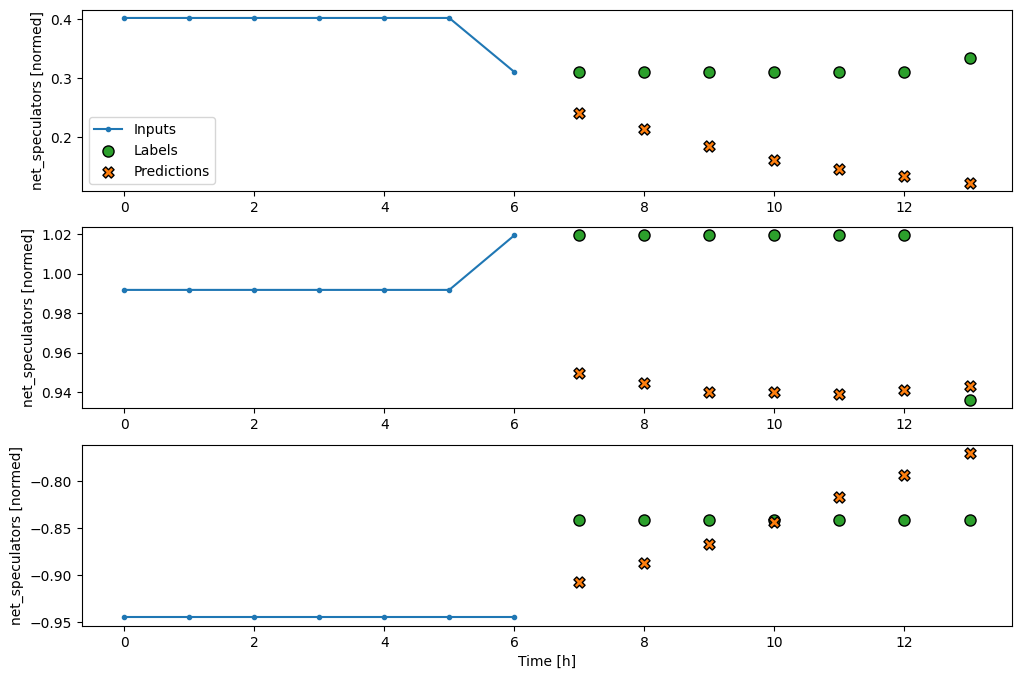

In [114]:
multi_window.plot(multi_lstm_model, 'net_speculators')

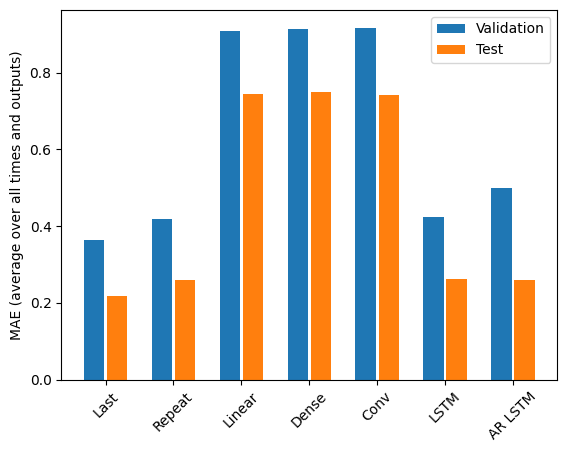

In [115]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

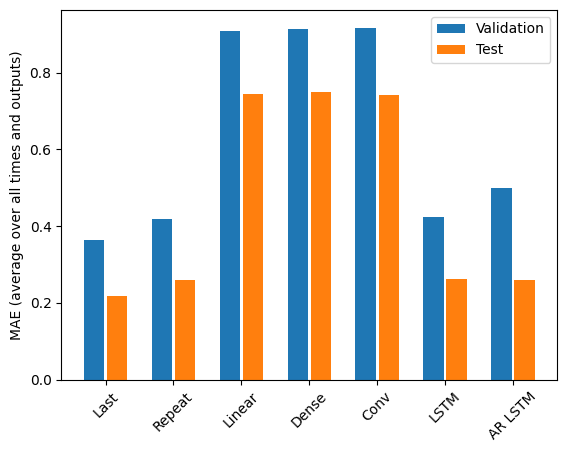

In [116]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [42]:

cot_df

,Date,net_speculators,spec_long_%,spec_short_%,Long/Short
0,2018-01-21,55281.97,7.42,0.08,92.750000
1,2018-01-28,55412.89,7.37,0.05,147.400000
2,2018-02-04,56881.56,5.97,0.11,54.272727
3,2018-02-11,43466.55,6.11,0.11,55.545455
4,2018-02-18,44053.00,6.10,0.13,46.923077
...,...,...,...,...,...
335,2024-06-23,-18197.75,4.43,6.89,0.642961
336,2024-06-30,-21215.03,5.13,8.23,0.623329
337,2024-07-07,-17487.03,5.22,7.67,0.680574
338,2024-07-14,-18113.99,5.00,7.48,0.668449
